Step 1: 数据已加载并转换时间格式。
Step 2: 已成功重采样为 M15 和 H1 时间框架。
Step 3 & 4: 已计算布林带和 MACD rsi。

M15 Analysis: {'Current Price': 2860.135, 'Bollinger Upper': 2863.8244187413165, 'Bollinger Lower': 2858.005781258683, 'Bollinger Width': 5.818637482633676, 'MACD': -1.4616709738161262, 'MACD Histogram': 0.18517980819609603, 'RSI': 40.70021881838053, 'ATVV': 5120.1, 'Trend': 'Bullish'}
H1 Analysis: {'Current Price': 2860.135, 'Bollinger Upper': 2876.265540518347, 'Bollinger Lower': 2854.307659481654, 'Bollinger Width': 21.957881036692925, 'MACD': 0.14558584033602529, 'MACD Histogram': -1.1039904675072343, 'RSI': 46.25688788289217, 'ATVV': 37750.8, 'Trend': 'Bearish'}


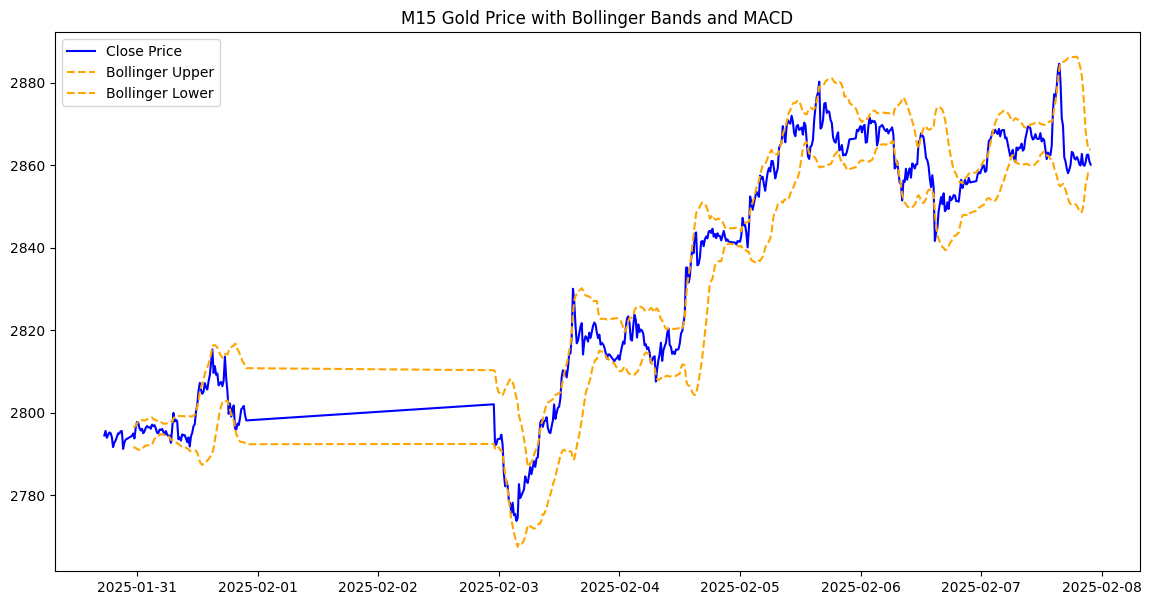

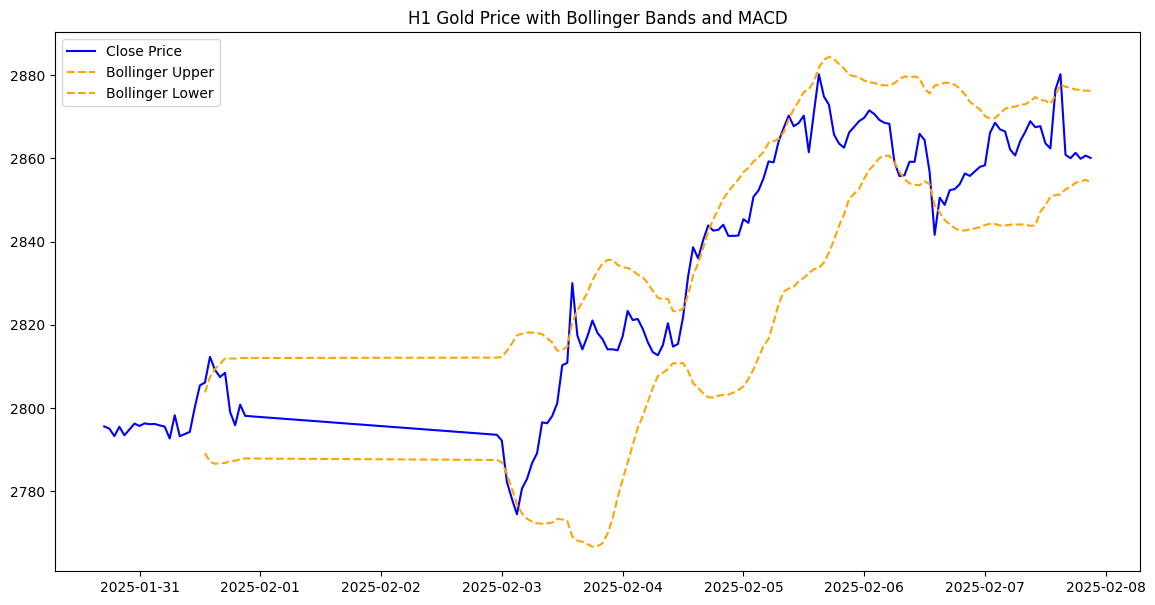

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Step 1: 读取并准备数据
def load_and_prepare_data(minute_file_path, day_file_path):
    """
    读取分钟数据和日线数据，转换时间格式并返回两个 DataFrame。
    """
    minute_data = pd.read_csv(minute_file_path)
    minute_data['time'] = pd.to_datetime(minute_data['time'], unit='s')
    minute_data.set_index('time', inplace=True)
    
    day_data = pd.read_csv(day_file_path)
    day_data['time'] = pd.to_datetime(day_data['time'])
    return minute_data, day_data

minute_data, day_data = load_and_prepare_data('data/130209min.csv', 'data/240209.csv')

print("Step 1: 数据已加载并转换时间格式。")

# Step 2: 重采样为 M15 和 H1 时间框架
m15_data = minute_data.resample('15T').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'ATVV': 'sum'  # 聚合 ATVV
}).dropna()
h1_data = minute_data.resample('1H').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'ATVV':'sum'
}).dropna()

print("Step 2: 已成功重采样为 M15 和 H1 时间框架。")
m15_data.head()
# Step 3: 计算布林带
def calculate_bollinger_bands(data, column='close', window=20):
    data['SMA_20'] = data[column].rolling(window=window).mean()
    data['std_20'] = data[column].rolling(window=window).std()
    data['bollinger_upper'] = data['SMA_20'] + (2 * data['std_20'])
    data['bollinger_lower'] = data['SMA_20'] - (2 * data['std_20'])
    data['bollinger_width'] = data['bollinger_upper'] - data['bollinger_lower']
    return data

# Step 4: 计算 MACD 和 rsi
def calculate_macd(data, column='close', short_span=12, long_span=26, signal_span=9):
    data['EMA_12'] = data[column].ewm(span=short_span, adjust=False).mean()
    data['EMA_26'] = data[column].ewm(span=long_span, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal'] = data['MACD'].ewm(span=signal_span, adjust=False).mean()
    data['MACD_histogram'] = data['MACD'] - data['Signal']
    return data
def calculate_rsi(data, column='close', window=14):
    delta = data[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data


# 计算布林带和 MACD
m15_data = calculate_bollinger_bands(m15_data)
m15_data = calculate_macd(m15_data)
m15_data = calculate_rsi(m15_data)
h1_data = calculate_bollinger_bands(h1_data)
h1_data = calculate_macd(h1_data)
h1_data = calculate_rsi(h1_data)
print("Step 3 & 4: 已计算布林带和 MACD rsi。")

# Step 4: 更新市场分析函数，包含 RSI 和 ATVV
def analyze_market(data):
    """
    分析市场状态，包含 Bollinger Bands、MACD、RSI 和 ATVV。
    """
    latest = data.iloc[-1]
    result = {
        "Current Price": latest['close'],
        "Bollinger Upper": latest['bollinger_upper'],
        "Bollinger Lower": latest['bollinger_lower'],
        "Bollinger Width": latest['bollinger_width'],
        "MACD": latest['MACD'],
        "MACD Histogram": latest['MACD_histogram'],
        "RSI": latest['RSI'],
        "ATVV": latest['ATVV'],
        "Trend": "Bullish" if latest['MACD'] > latest['Signal'] else "Bearish"
    }
    return result

m15_analysis = analyze_market(m15_data)
h1_analysis = analyze_market(h1_data)
print("\nM15 Analysis:", m15_analysis)
print("H1 Analysis:", h1_analysis)

# Step 6: 可视化布林带和价格走势
def plot_bollinger_bands(data, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['close'], label='Close Price', color='blue')
    plt.plot(data.index, data['bollinger_upper'], label='Bollinger Upper', linestyle='--', color='orange')
    plt.plot(data.index, data['bollinger_lower'], label='Bollinger Lower', linestyle='--', color='orange')
    plt.title(title)
    plt.legend()
    plt.show()

plot_bollinger_bands(m15_data, "M15 Gold Price with Bollinger Bands and MACD")
plot_bollinger_bands(h1_data, "H1 Gold Price with Bollinger Bands and MACD")


In [130]:
def load_data(path:list,type='m'):
    r_data = []
    for file in path:
        data = pd.read_csv(file)
        if type == 'm':
            data['time'] = pd.to_datetime(data['time'], unit='s')
            #data.set_index('time',inplace=True)
            r_data.append(data)
        elif type == 'd':
            data['time'] = pd.to_datetime(data['time'],unit='s')
            r_data.append(data)
    return r_data

In [115]:


def RSI_Wilder(data, period=14):
    """
    使用 Wilder’s Smoothing Method (RMA) 计算 RSI。

    参数：
    - data: 必须包含 'close' 列的 Pandas DataFrame
    - period: 默认 14

    返回：
    - 在原 DataFrame 中添加一列 'RSI', 并返回
    """
    # 1) 计算收盘价变化 delta
    delta = data['close'].diff(1)
    
    # 2) 计算涨幅（gain）和跌幅（loss）
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    # 3) 使用前 period 条数据，计算初始均值 (简单平均)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    
    # 4) 创建数组来存储 Wilder’s 平滑结果 (RMA)
    rma_gain = np.zeros_like(gain)
    rma_loss = np.zeros_like(loss)
    
    rma_gain[:period] = np.nan
    rma_loss[:period] = np.nan

    # 5) 找到第一个非 NaN 的索引，作为初始值
    first_valid = period
    
    if len(data) >= period:
        rma_gain[first_valid] = avg_gain.iloc[first_valid]
        rma_loss[first_valid] = avg_loss.iloc[first_valid]
        
        # 6) 从第 (period+1) 行开始，Wilder’s 平滑递推
        for i in range(first_valid + 1, len(data)):
            rma_gain[i] = (rma_gain[i-1] * (period - 1) + gain.iloc[i]) / period
            rma_loss[i] = (rma_loss[i-1] * (period - 1) + loss.iloc[i]) / period
    
    # 7) 计算 RSI
    RS = rma_gain / rma_loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    # 将 RSI 值写回 DataFrame
    data['RSI_Wilder'] = RSI
    
    return data


In [131]:
def MACD(data, short_window=12, long_window=26, signal_window=9):
    """
    计算 MACD 指标。
    
    参数：
    - data: 包含 `close` 列的 Pandas DataFrame
    - short_window: 短期 EMA 的周期，默认是 12
    - long_window: 长期 EMA 的周期，默认是 26
    - signal_window: 信号线 EMA 的周期，默认是 9

    返回：
    - 带有 MACD 线、信号线和柱状图的新 DataFrame，新增列 `MACD`, `Signal`, `Histogram`
    """
    # 计算短期和长期 EMA
    short_ema = data['close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['close'].ewm(span=long_window, adjust=False).mean()
    
    # 计算 MACD 线
    data['MACD'] = short_ema - long_ema
    
    # 计算信号线（MACD 线的 9 周期 EMA）
    data['Signal'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    # 计算 MACD 柱状图
    data['Histogram'] = data['MACD'] - data['Signal']
    
    return data


In [ ]:
# def Bollinger_Bands(data, window=20, num_std=2):
#     """
#     计算布林带 (Bollinger Bands)。
    
#     参数：
#     - data: 包含 `close` 列的 Pandas DataFrame
#     - window: 移动平均窗口大小，默认是 20
#     - num_std: 标准差倍数，默认是 2
    
#     返回：
#     - 带有布林带新增列 `BB_Middle`, `BB_Upper`, `BB_Lower` 的 Pandas DataFrame
#     """
#     # 计算中轨（简单移动平均）
#     data['BB_Middle'] = data['close'].rolling(window=window).mean()
    
#     # 计算标准差
#     data['BB_Std'] = data['close'].rolling(window=window).std()
    
#     # 计算上轨和下轨
#     data['BB_Upper'] = data['BB_Middle'] + num_std * data['BB_Std']
#     data['BB_Lower'] = data['BB_Middle'] - num_std * data['BB_Std']
    
#     return data

In [132]:
def Bollinger_Bands(data, window=20, num_std=2, calc_relative_width=False):
    """
    计算布林带 (Bollinger Bands) 及布林带宽度。
    
    参数：
    - data: 包含 'close' 列的 Pandas DataFrame
    - window: 移动平均窗口大小，默认是 20
    - num_std: 标准差倍数，默认是 2
    - calc_relative_width: 是否计算相对宽度, 默认为 False
    
    返回：
    - 带有布林带新增列的 Pandas DataFrame:
      'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', (可选) 'BB_Ratio'
    """
    # 计算中轨（简单移动平均）
    data['BB_Middle'] = data['close'].rolling(window=window).mean()
    
    # 计算标准差
    data['BB_Std'] = data['close'].rolling(window=window).std()
    
    # 计算上轨和下轨
    data['BB_Upper'] = data['BB_Middle'] + num_std * data['BB_Std']
    data['BB_Lower'] = data['BB_Middle'] - num_std * data['BB_Std']
    
    # 计算布林带绝对宽度
    data['BB_Width'] = data['BB_Upper'] - data['BB_Lower']
    
    # 如果需要，计算布林带相对宽度
    if calc_relative_width:
        data['BB_Ratio'] = data['BB_Width'] / data['BB_Middle']
    
    return data


In [133]:
import numpy as np
import matplotlib.pyplot as plt

def plot_support_resistance_with_atvv(
    data,
    column='close',
    atvv_column='ATVV',
    lower_band_column='BB_Lower',
    upper_band_column='BB_Upper',
    rsi_column='RSI_Wilder',
    macd_column='MACD',
    signal_column='Signal',
    quantile_threshold=0.8,
    rsi_oversold=30,
    rsi_overbought=70,
    strategy=1,
    last_n_points=96
):
    """
    自动标记并绘制更精细的局部支撑/阻力，结合多重指标：
    - 布林带上下轨 (BB_Lower, BB_Upper)
    - 成交量 (ATVV)
    - RSI (RSI_Wilder)
    - MACD 及其 Signal
    
    参数：
    ----------
    data : pd.DataFrame
        包含行情数据、布林带、ATVV、RSI、MACD 等列。
    column : str
        价格列名，默认 'close'。
    atvv_column : str
        成交量或活跃度列，默认 'ATVV'。
    lower_band_column : str
        布林带下轨列名，默认 'BB_Lower'。
    upper_band_column : str
        布林带上轨列名，默认 'BB_Upper'。
    rsi_column : str
        RSI 指标列名，默认 'RSI_Wilder'。
    macd_column : str
        MACD 指标列名，默认 'MACD'。
    signal_column : str
        MACD 信号线列名，默认 'Signal'。
    quantile_threshold : float
        ATVV 的分位数阈值，用来筛选 “高成交量点”。默认 0.8（即超过 80% 分位数）。
    rsi_oversold : int
        RSI 超卖阈值，默认 30。
    rsi_overbought : int
        RSI 超买阈值，默认 70。
    strategy : int
        选择哪种策略：
         - 1: 布林带 + ATVV  (你的原逻辑)
         - 2: 布林带 + ATVV + RSI + MACD (示例：更苛刻的多重条件)
    last_n_points : int
        只分析最近 N 条数据，默认 96。
        
    返回：
    ----------
    dict
        包含 'dynamic_support_levels' 和 'dynamic_resistance_levels' 两个列表，
        列表元素是 (time, price) 的元组。
    """
    # 只分析最近的 n 个数据点
    data = data.tail(last_n_points).reset_index(drop=True)
    
    # 获取关键数据
    prices     = data[column].values
    atvv       = data[atvv_column].values
    lower_band = data[lower_band_column].values
    upper_band = data[upper_band_column].values
    
    # 可能的其它指标
    rsi   = data[rsi_column].values if rsi_column in data.columns else None
    macd  = data[macd_column].values if macd_column in data.columns else None
    sig   = data[signal_column].values if signal_column in data.columns else None
    
    # 计算 ATVV 阈值
    atvv_high = np.quantile(atvv, quantile_threshold) if len(atvv) > 0 else 0
    
    support_levels = []
    resistance_levels = []
    
    for i in range(len(prices)):
        price_i = prices[i]
        time_i  = data['time'].iloc[i]  # 如果 time 在 index 而不是列，则改用 data.index[i] 或重置索引后 data.iloc[i].name
        
        # ================ STRATEGY 1 ================
        if strategy == 1:
            # 简单：价格触及布林带上下轨 + ATVV 大于某阈值
            if (price_i <= lower_band[i]) and (atvv[i] >= atvv_high):
                support_levels.append((time_i, price_i))
            if (price_i >= upper_band[i]) and (atvv[i] >= atvv_high):
                resistance_levels.append((time_i, price_i))
        
        # ================ STRATEGY 2 ================
        elif strategy == 2:
            # 更苛刻的条件：
            # 1) 触及布林带上下轨 + ATVV 高
            # 2) RSI 指标满足超卖/超买
            # 3) MACD 的多空方向支持
            #    - 如果是支撑：RSI < rsi_oversold, 并且 MACD > Signal （看多倾向）
            #    - 如果是阻力：RSI > rsi_overbought, 并且 MACD < Signal （看空倾向）
            
            if (price_i <= lower_band[i]) and (atvv[i] >= atvv_high):
                # RSI < 超卖阈值 & MACD > 信号线 => 潜在买点
                if (rsi is not None and rsi[i] < rsi_oversold) and \
                   (macd is not None and sig is not None and macd[i] > sig[i]):
                    support_levels.append((time_i, price_i))
            
            if (price_i >= upper_band[i]) and (atvv[i] >= atvv_high):
                # RSI > 超买阈值 & MACD < 信号线 => 潜在卖点
                if (rsi is not None and rsi[i] > rsi_overbought) and \
                   (macd is not None and sig is not None and macd[i] < sig[i]):
                    resistance_levels.append((time_i, price_i))
                    
        else:
            raise ValueError("Unsupported strategy. Choose 1 or 2.")
    
    # ========== 绘图部分 ==========
    plt.figure(figsize=(14, 7))
    plt.plot(data['time'], data[column], label='Price', color='blue')
    plt.plot(data['time'], data[lower_band_column], label='Lower Band', linestyle='--', color='green')
    plt.plot(data['time'], data[upper_band_column], label='Upper Band', linestyle='--', color='red')
    
    if support_levels:
        times_s, prices_s = zip(*support_levels)
        plt.scatter(times_s, prices_s, color='purple', marker='^', label='Support')
    if resistance_levels:
        times_r, prices_r = zip(*resistance_levels)
        plt.scatter(times_r, prices_r, color='orange', marker='v', label='Resistance')
    
    plt.title(f"Strategy {strategy} - Dynamic Support/Resistance (Last {last_n_points} pts)")
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 返回支撑/阻力位置
    return {
        'dynamic_support_levels': support_levels,
        'dynamic_resistance_levels': resistance_levels
    }


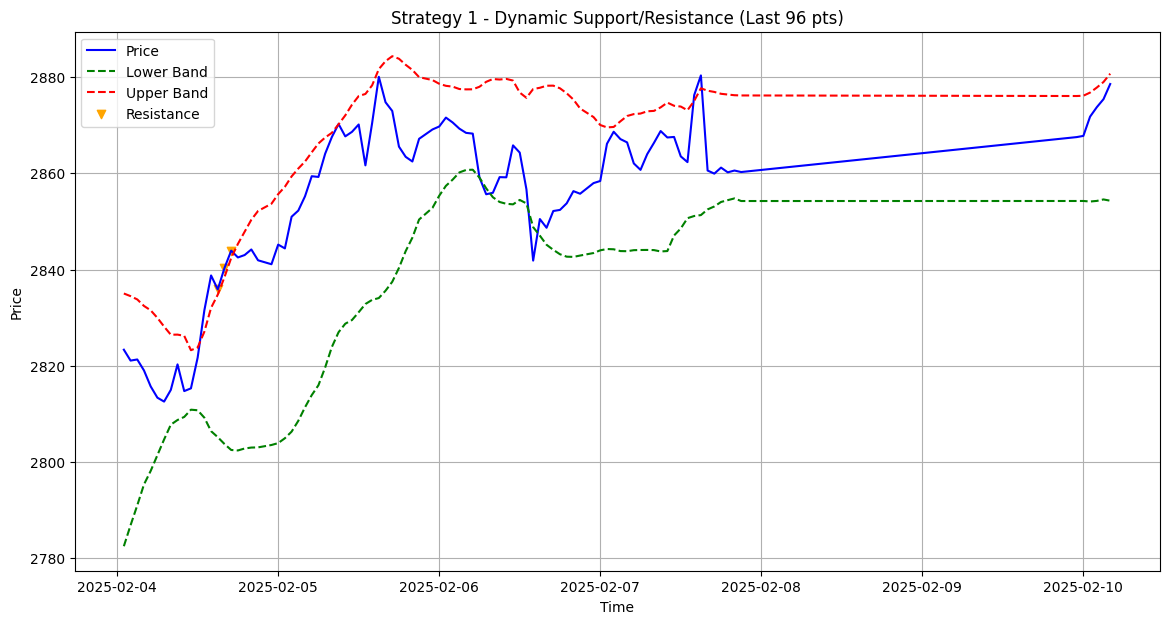

{'dynamic_support_levels': [],
 'dynamic_resistance_levels': [(Timestamp('2025-02-04 15:00:00'), 2835.88),
  (Timestamp('2025-02-04 16:00:00'), 2840.35),
  (Timestamp('2025-02-04 17:00:00'), 2843.94)]}

In [140]:
def main():
    m15 = load_data(['data/15min.csv'])
    h1 = load_data(['data/h1.csv'])
    m15=Bollinger_Bands(MACD(RSI_Wilder(m15)))
    h1 = Bollinger_Bands(MACD(RSI_Wilder(h1)))
m15 = MACD(RSI_Wilder(m15))
m15=Bollinger_Bands(m15)
h1 = MACD(RSI_Wilder(h1))
h1=Bollinger_Bands(h1)
plot_support_resistance_with_atvv(h1)

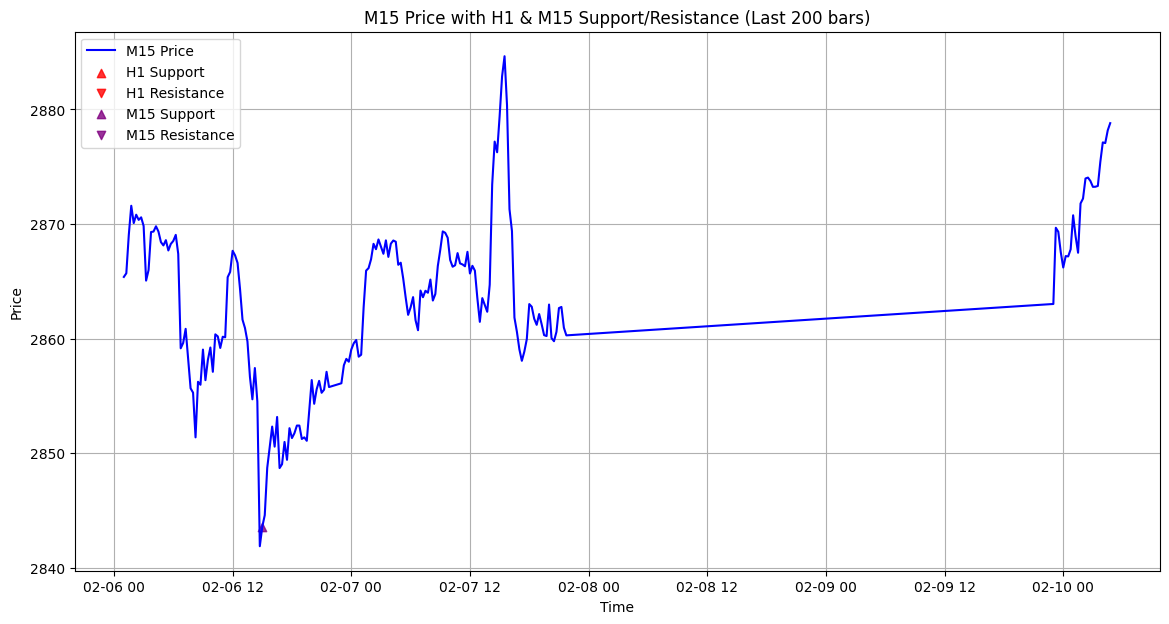

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============== 1. 基于“布林带+ATVV+RSI”识别支撑/阻力的核心函数 ==============
def find_extrema(
    data,
    price_col='close',
    lower_col='BB_Lower',
    upper_col='BB_Upper',
    rsi_col='RSI_Wilder',
    atvv_col='ATVV',
    atvv_quantile=0.8,
    rsi_oversold=30,
    rsi_overbought=70
):
    """
    使用“布林带 + ATVV + RSI”来识别支撑(局部低点)和阻力(局部高点)，
    并分别返回 max_idx、min_idx 两个列表索引。
    
    识别逻辑 (可根据需求自行调整)：
      - 支撑:
        1) close <= BB_Lower
        2) ATVV >= atvv_col 的分位数阈值 (默认为 80% 分位)
        3) RSI < rsi_oversold (默认 30)
      - 阻力:
        1) close >= BB_Upper
        2) ATVV >= atvv_col 的分位数阈值 (默认为 80% 分位)
        3) RSI > rsi_overbought (默认 70)
    """
    df = data.reset_index(drop=True)
    
    # 计算 ATVV 的分位数阈值
    atvv_threshold = df[atvv_col].quantile(atvv_quantile) if len(df) > 0 else 0
    
    max_idx = []
    min_idx = []
    
    for i in range(len(df)):
        price_i = df.loc[i, price_col]
        lower_i = df.loc[i, lower_col]
        upper_i = df.loc[i, upper_col]
        rsi_i   = df.loc[i, rsi_col]
        atvv_i  = df.loc[i, atvv_col]
        
        # ------ 判断支撑 (局部低点) ------
        if (price_i <= lower_i) and (atvv_i >= atvv_threshold) and (rsi_i < rsi_oversold):
            min_idx.append(i)
        
        # ------ 判断阻力 (局部高点) ------
        if (price_i >= upper_i) and (atvv_i >= atvv_threshold) and (rsi_i > rsi_overbought):
            max_idx.append(i)
    
    return max_idx, min_idx


# ============== 2. 在大周期 (H1) 数据上计算支撑/阻力 =================
def get_h1_levels(data_h1, price_col='close'):
    """
    在 H1 数据上找支撑/阻力点位，返回一个 DataFrame。
    """
    df = data_h1.copy().reset_index(drop=True)
    max_idx, min_idx = find_extrema(df,atvv_quantile=0.68)  # 使用上面自定义的布林带+ATVV+RSI函数
    
    # 将结果转成 DataFrame
    h1_support = df.loc[min_idx, ['time', price_col]].copy()
    h1_resist  = df.loc[max_idx, ['time', price_col]].copy()
    
    h1_support['type'] = 'support'
    h1_resist['type']  = 'resistance'
    
    levels = pd.concat([h1_support, h1_resist]).reset_index(drop=True)
    return levels


# ============== 3. 在小周期 (M15) 数据上进行更精细的识别 ==============
def get_m15_levels(data_m15, price_col='close'):
    """
    在 M15 数据上找支撑/阻力点位，返回一个 DataFrame。
    """
    df = data_m15.copy().reset_index(drop=True)
    max_idx, min_idx = find_extrema(df)
    
    m15_support = df.loc[min_idx, ['time', price_col]].copy()
    m15_resist  = df.loc[max_idx, ['time', price_col]].copy()
    
    m15_support['type'] = 'support'
    m15_resist['type']  = 'resistance'
    
    levels = pd.concat([m15_support, m15_resist]).reset_index(drop=True)
    return levels


# ============== 4. 在 M15 图上叠加显示 H1 和 M15 的关键位 ==============
def plot_multi_timeframe_s_r(m15_data, h1_levels, m15_levels, price_col='close', last_n_points=200):
    """
    - m15_data: 15分钟 K线数据 (包含 time, close 等列)
    - h1_levels: 大周期(H1)提取的支撑/阻力位置 (含 columns: time, price_col, type)
    - m15_levels: 15分钟(M15)自身提取的支撑/阻力
    - last_n_points: 只绘制 M15 的最近多少条数据 (默认200)
    """
    # 只看最近 N 条
    df_m15 = m15_data.tail(last_n_points).copy()
    
    # 画 M15 的价格
    plt.figure(figsize=(14, 7))
    plt.plot(df_m15['time'], df_m15[price_col], label='M15 Price', color='blue')
    
    # 在同一时段上标记出 H1 支撑/阻力
    start_t = df_m15['time'].iloc[0]
    end_t   = df_m15['time'].iloc[-1]
    
    mask_h1 = (h1_levels['time'] >= start_t) & (h1_levels['time'] <= end_t)
    h1_in_range = h1_levels[mask_h1]
    h1_support = h1_in_range[h1_in_range['type']=='support']
    h1_resist  = h1_in_range[h1_in_range['type']=='resistance']
    
    plt.scatter(h1_support['time'], h1_support[price_col], 
                marker='^', color='red', alpha=0.8, label='H1 Support')
    plt.scatter(h1_resist['time'], h1_resist[price_col], 
                marker='v', color='red', alpha=0.8, label='H1 Resistance')
    
    # 在同一时段上标记出 M15 支撑/阻力
    mask_m15 = (m15_levels['time'] >= start_t) & (m15_levels['time'] <= end_t)
    m15_in_range = m15_levels[mask_m15]
    m15_support = m15_in_range[m15_in_range['type']=='support']
    m15_resist  = m15_in_range[m15_in_range['type']=='resistance']
    
    plt.scatter(m15_support['time'], m15_support[price_col], 
                marker='^', color='purple', alpha=0.8, label='M15 Support')
    plt.scatter(m15_resist['time'], m15_resist[price_col], 
                marker='v', color='purple', alpha=0.8, label='M15 Resistance')
    
    plt.title(f"M15 Price with H1 & M15 Support/Resistance (Last {last_n_points} bars)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


# ============== 5. 可选的独立绘制函数 (只看一张布林带+ATVV+RSI走势) ==============
def plot_extrema_bollinger_atvv_rsi(data):
    """
    针对一张表 (任意周期) 直接绘制 Bollinger+ATVV+RSI 找到的支撑/阻力散点。
    """
    max_idx, min_idx = find_extrema(data)
    
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['close'], label='Price')
    plt.plot(data.index, data['BB_Upper'], 'r--', label='BB Upper')
    plt.plot(data.index, data['BB_Lower'], 'g--', label='BB Lower')
    
    plt.scatter(max_idx, data.loc[max_idx, 'close'], color='red', marker='v', label='Resistance')
    plt.scatter(min_idx, data.loc[min_idx, 'close'], color='green', marker='^', label='Support')
    
    plt.title('Bollinger+ATVV+RSI Extrema')
    plt.legend()
    plt.grid(True)
    plt.show()


# ============== 6. 主流程示例 (可替换成真实数据加载) ==============
def main():
    """
    示例主流程：
      1) 构造或加载 M15、H1 数据 (带有 time, close, BB_Upper, BB_Lower, RSI_Wilder, ATVV 等列)
      2) 分别提取 H1、M15 支撑/阻力 (get_h1_levels, get_m15_levels)
      3) 在 M15 图上叠加显示 H1、M15 SR (plot_multi_timeframe_s_r)
      4) (可选) 对单个周期独立画布林带+ATVV+RSI (plot_extrema_bollinger_atvv_rsi)
    """
    
    
    
    # ====== 2) 分别获取 H1、M15 的支撑/阻力 ======
    h1_levels = get_h1_levels(h1, price_col='close')
    m15_levels = get_m15_levels(m15, price_col='close')
    
    # ====== 3) 在 M15 图表上叠加显示 H1、M15 的 SR ======
    plot_multi_timeframe_s_r(m15, h1_levels, m15_levels, price_col='close', last_n_points=200)
    
    # ====== 4) (可选) 对单周期独立绘制布林带+ATVV+RSI 标注 ======
    # plot_extrema_bollinger_atvv_rsi(m15)   # 看看15min效果
    # plot_extrema_bollinger_atvv_rsi(h1)    # 看看1h效果
    
    return m15, h1, h1_levels, m15_levels


if __name__ == "__main__":
    m15_data, h1_data, h1_lvls, m15_lvls = main()


In [138]:
def find_support_resistance_levels(
    data,
    column='close',
    atvv_column='ATVV',
    lower_band_column='BB_Lower',
    upper_band_column='BB_Upper',
    rsi_column='RSI_Wilder',
    macd_column='MACD',
    signal_column='Signal',
    quantile_threshold=0.8,
    rsi_oversold=30,
    rsi_overbought=70,
    strategy=1,
    last_n_points=96
):
    """
    识别历史支撑/阻力点，并返回一个 List[dict] 结构，
    每个 dict 包含 { 'time': ..., 'price': ..., 'type': 'support' or 'resistance' }。
    
    参数和逻辑与之前示例类似，只是把绘图拿掉，把结果保存到列表里。
    """
    # 只分析最近的 n 个数据点
    df = data.tail(last_n_points).reset_index(drop=True)
    
    prices     = df[column].values
    atvv       = df[atvv_column].values
    lower_band = df[lower_band_column].values
    upper_band = df[upper_band_column].values
    
    # 可能的其它指标
    rsi   = df[rsi_column].values if rsi_column in df.columns else None
    macd  = df[macd_column].values if macd_column in df.columns else None
    sig   = df[signal_column].values if signal_column in df.columns else None
    
    # 计算 ATVV 阈值
    atvv_high = np.quantile(atvv, quantile_threshold) if len(atvv) > 0 else 0
    
    levels_list = []  # 用于存放 (time, price, type)
    
    for i in range(len(prices)):
        price_i = prices[i]
        time_i  = df['time'].iloc[i]  # 如果 time 在 index，就用 df.index[i] 或先 reset_index
        
        if strategy == 1:
            # 简单：价格触及布林带上下轨 + ATVV 大于某阈值
            if (price_i <= lower_band[i]) and (atvv[i] >= atvv_high):
                levels_list.append({'time': time_i, 'price': price_i, 'type': 'support'})
            if (price_i >= upper_band[i]) and (atvv[i] >= atvv_high):
                levels_list.append({'time': time_i, 'price': price_i, 'type': 'resistance'})
        
        elif strategy == 2:
            # 布林带 + ATVV + RSI + MACD 等更严格条件 (示例)
            if (price_i <= lower_band[i]) and (atvv[i] >= atvv_high):
                # RSI < 超卖 & MACD > Signal => 支撑
                if (rsi is not None and rsi[i] < rsi_oversold) and \
                   (macd is not None and sig is not None and macd[i] > sig[i]):
                    levels_list.append({'time': time_i, 'price': price_i, 'type': 'support'})
            if (price_i >= upper_band[i]) and (atvv[i] >= atvv_high):
                # RSI > 超买 & MACD < Signal => 阻力
                if (rsi is not None and rsi[i] > rsi_overbought) and \
                   (macd is not None and sig is not None and macd[i] < sig[i]):
                    levels_list.append({'time': time_i, 'price': price_i, 'type': 'resistance'})
        else:
            raise ValueError("Unsupported strategy. Choose 1 or 2.")
    
    return levels_list

find_support_resistance_levels(m15)
find_support_resistance_levels(h1)

[{'time': Timestamp('2025-02-04 15:00:00'),
  'price': 2835.88,
  'type': 'resistance'},
 {'time': Timestamp('2025-02-04 16:00:00'),
  'price': 2840.35,
  'type': 'resistance'},
 {'time': Timestamp('2025-02-04 17:00:00'),
  'price': 2843.94,
  'type': 'resistance'}]